# Stock Analysis Using LSTM - MVP
This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Import required libraries and set up notebook


In [252]:
import pandas as pd
import numpy as np
import os
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.models import Model
# from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
# access datasets from quandl.com - need to pip install Quandl to use
import quandl
on_colab = False
verboseout = True
look_back = 3
config_file = 'model_training_config.yml'

In [253]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [254]:
if on_colab:
    %cd /content/drive/MyDrive/karma_jan_2021/stock_investigation/notebooks

# Load config parameters

In [255]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, config_file)
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: C:\personal\karma_stocks_2021\stock_investigation\notebooks
path_to_yaml C:\personal\karma_stocks_2021\stock_investigation\notebooks\model_training_config.yml


In [256]:
# switches
plot_all = config['general']['verboseout']
use_saved_model = config['general']['presaved']
ust_cols = config['general']['ust_cols']
# list of ticket symbols
# e.g. tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
tech_list = config['tech_list']
# dictionary to seed stock handles with company names
# e.g. company_dict = {'AAPL':"APPLE", 'GOOG':"GOOGLE", 'MSFT':"MICROSOFT", 'AMZN':"AMAZON"}
company_dict = config['company_dict']
saved_model_modifier = config['files']['saved_model_modifier']
# get the column lists
continuouscols = config['categorical']
textcols = config['text']
collist = config['continuous']
years_window = config['general']['years_window']
quandl_token = config['general']['quandl_token']
look_back = config['general']['look_back']

In [257]:
config

{'general': {'verboseout': False,
  'includetext': True,
  'on_colab': False,
  'presaved': False,
  'savemodel': True,
  'picklemodel': True,
  'save_model_plot': False,
  'tensorboard_callback': False,
  'hctextmax': 7000,
  'maxwords': 6000,
  'textmax': 50,
  'pickled_data_file': '20142018_0930.pkl',
  'pickled_dataframe': 'AB_NYC_2019_output_aug19_2020.pkl',
  'modifier': 'oct05_2020',
  'targetthresh': 6.0,
  'targetcontinuous': False,
  'target_col': 'price',
  'emptythresh': 6000,
  'zero_weight': 1.0,
  'one_weight': 45.878,
  'one_weight_offset': 0,
  'patience_threshold': 3,
  'master_start': '2018-01-01',
  'ust_cols': ['2 YR'],
  'years_window': 2,
  'quandl_token': 'uCghYBw8CtpUvWct_W8c',
  'look_back': 3},
 'files': {'saved_model_modifier': 'January312021'},
 'tech_list': ['CROX'],
 'company_dict': {'CROX': 'Crocs'},
 'test_parms': {'testproportion': 0.2,
  'trainproportion': 0.8,
  'current_experiment': 5,
  'repeatable_run': False,
  'get_test_train_acc': True},
 'cate

# Load US Treasury stats

In [258]:
# load US Treasury yield dataframe
ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)

In [259]:
ust_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.06,0.07,0.07,0.08,0.08,0.11,0.17,0.42,0.76,1.09,1.66,1.84
2021-02-02,0.04,0.05,0.07,0.08,0.08,0.11,0.18,0.45,0.79,1.12,1.69,1.87
2021-02-03,0.03,0.04,0.04,0.06,0.08,0.11,0.19,0.46,0.81,1.15,1.73,1.92


In [260]:
# new = old[['A', 'C', 'D']].copy()
ust_df_2year = ust_df[['2 YR']].copy()
ust_df_2year.head()

,2 YR
Date,
1990-01-02,7.87
1990-01-03,7.94
1990-01-04,7.92
1990-01-05,7.90
1990-01-08,7.90


In [261]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
tester = DataReader('AAPL', 'yahoo', start, end)
tester.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-02-06,81.305000,80.065002,80.642502,81.302498,105425600.0,80.486107
2020-02-07,80.849998,79.500000,80.592499,80.007500,117684000.0,79.392090
2020-02-10,80.387497,78.462502,78.544998,80.387497,109348800.0,79.769165
2020-02-11,80.974998,79.677498,80.900002,79.902496,94323200.0,79.287888
2020-02-12,81.805000,80.367500,80.367500,81.800003,113730400.0,81.170799


In [262]:
# The tech stocks used for this analysis
#tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
tech_list = config['tech_list']
# dictionary to seed stock handles with company names
#company_dict = {'AAPL':"APPLE", 'GOOG':"GOOGLE", 'MSFT':"MICROSOFT", 'AMZN':"AMAZON"}
company_dict = config['company_dict']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

stock_dict = {}
#For loop for grabing yahoo finance data and setting as a dataframe
# TODO correct use of globals() here
seeded = False
for stock in tech_list:   
    # Set DataFrame as the Stock Ticker
    stock_dict[stock] = DataReader(stock, 'yahoo', start, end)
    # add column for company name
    stock_dict[stock]['company_name'] = company_dict[stock]
    # build up overall dataframe containing stock info for all companies
    if seeded:
        df = pd.concat([df,stock_dict[stock]],axis=0)
    else:
        seeded = True
        df = stock_dict[stock]
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2021-01-25,74.750000,71.050003,73.180000,73.910004,1102500,73.910004,Crocs
2021-01-26,74.690002,71.800003,74.559998,72.239998,819000,72.239998,Crocs
2021-01-27,70.430000,65.370003,70.430000,65.800003,2100100,65.800003,Crocs
2021-01-28,70.809998,66.699997,67.230003,70.370003,1414100,70.370003,Crocs
2021-01-29,72.070000,68.500000,70.139999,70.019997,1264100,70.019997,Crocs
2021-02-01,72.980003,68.580002,71.000000,72.769997,836800,72.769997,Crocs
2021-02-02,76.089996,73.320000,73.720001,75.459999,1424900,75.459999,Crocs
2021-02-03,77.120003,73.949997,75.889999,74.930000,736700,74.930000,Crocs
2021-02-04,76.800003,74.169998,75.300003,75.040001,615000,75.040001,Crocs


In [263]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2020-02-06,39.750000,39.090000,39.439999,39.169998,337800,39.169998,Crocs
2020-02-07,39.470001,37.700001,39.139999,37.840000,931200,37.840000,Crocs
2020-02-10,38.000000,36.439999,37.779999,36.490002,1049500,36.490002,Crocs
2020-02-11,37.200001,36.110001,36.560001,36.520000,811300,36.520000,Crocs
2020-02-12,38.480000,36.759998,36.759998,37.860001,1040100,37.860001,Crocs


Let's go ahead and play aorund with the AAPL DataFrame to get a feel for the data

# Create dataframe

# 2. What was the moving average of the various stocks?

In [264]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in tech_list:
        column_name = f"MA for {ma} days"
        stock_dict[company][column_name] = stock_dict[company]['Adj Close'].rolling(ma).mean()

# 6. Predicting closing stock prices

In [265]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
df_predict = {}
# start='2012-01-01'
for company in tech_list:
    df_predict[company] = DataReader(company,data_source='yahoo', start=config['general']['master_start'], end=datetime.now())
    df_predict[company] = pd.merge(df_predict[company],ust_df[ust_cols],on=['Date'],how='inner')
    # add
    # show an example
df_predict[tech_list[0]].head()

,High,Low,Open,Close,Volume,Adj Close,2 YR
Date,,,,,,,
2018-01-02,12.98,12.58,12.64,12.97,778900,12.97,1.92
2018-01-03,13.14,12.83,12.99,12.90,1200900,12.90,1.94
2018-01-04,12.98,12.51,12.91,12.70,813900,12.70,1.96
2018-01-05,12.24,11.65,12.05,12.20,1893100,12.20,1.96
2018-01-08,13.55,12.52,12.53,13.23,2862900,13.23,1.96


In [266]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [267]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [268]:
def get_save_model_path(company):
    model_path = get_model_path()
    modifier = saved_model_modifier
    # modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    return(save_model_path)

In [269]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [270]:
def multi_col_df(df,cols):
    print("cols is:", cols)
    #data = df.filter(cols)
    data = df[cols]
    print("data inside is:",data)
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [271]:
def get_keras_vars(dataset):
    '''cribbed from traditional DL on structured data code'''
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

In [272]:
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return(scaled_data,scaler)

In [273]:
def create_x_y(scaled_data,training_data_len,look_back,input_col_count):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    print("scaled_data shape: ",str(scaled_data.shape))
    print('training_data_len: ',training_data_len)
    train_data = scaled_data[0:int(training_data_len), :]
    print("train_data shape is: ",train_data.shape)
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    print("len(train_data): ",str(len(train_data)))
    # here, each x is a set of look_back values and each y is the next value
    # a = dataset[i:(i + look_back), :]
    for i in range(len(train_data) - look_back - 1):
        a = train_data[i:(i + look_back), :]
        x_train.append(a)
        y_train.append(train_data[i, 0])
        
    '''for i in range(look_back, len(train_data)):
        x_train.append(train_data[i-look_back:i, 0])
        y_train.append(train_data[i, 0])
        if (i<= (look_back+1)) and plot_all:
            print(x_train)
            print(y_train)
            print()'''
   

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [274]:
def build_model(x_train,y_train,optimizer,loss_function):
        '''build simple model given x, y, optimizer and loss function - sequential API'''
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [275]:
def build_model_func(x_train,y_train,optimizer,loss_function,input_dim):
        '''build simple model given x, y, optimizer and loss function - functional API'''
        '''reference https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
            and https://stackoverflow.com/questions/42532386/how-to-work-with-multiple-inputs-for-lstm-in-keras'''
        lstminputs = {}
        inputlayerlist = []
        col = "holder"
        #lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        lstminputs[col] = Input(shape=(x_train.shape[1],input_dim),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        
        #output = Dense(1, activation=output_activation) (lstminputs[col])
        output = Dense(1) (lstminputs[col])
        # define model

        model = Model(inputlayerlist, output)

        
        
 
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [276]:
def build_model_func2(x_train,y_train,optimizer,loss_function,collist,continuouscols,lstmcols):
    '''build multi-input functional API model
    collist - list of categorical columns
    continuouscols - list of continuous columns
    
    want to have x_train being a list of numpy arrays, 
    one for each column that we want to create layers for
    
    
    
    '''
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    lstminput = {} # list of lstm inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    inputlayerlist = []
    

    
    '''
    for col in lstmcols:
        lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        # question here whether to include a dense layer or not at the end of LSTM 
        '''
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
        
    return(model)

In [277]:
%%time
# train models for each company in tech_list and save trained models
predictions = {}
data = {}
for company in tech_list:
    #data[company],dataset,training_data_len = one_col_df(df_predict[company],'Close')
    data[company],dataset,training_data_len = multi_col_df(df_predict[company],['Close','2 YR'])
    # X, dictlist get_keras_vars(df_predict[company])
    #print("dataset is: ",dataset)
    #print(("data[company] is:",data[company]))
    print("training_data_len: ",training_data_len)
    print("dataset shape: ",str(dataset.shape))
    #scaled_data, scaler = scale_data(dataset)
    scaled_data, scaler = scale_data(data[company])
    x_train, y_train = create_x_y(scaled_data,training_data_len,look_back,2)
    print("x_train is: ",x_train)
    print("y_train is: ",y_train)
    print("x_train shape: ",x_train.shape)
    print("y_train shape: ",y_train.shape)
    print("TRAINING LOOP FOR: ",str(company))
    '''
    turn off for experiment with multi columns
    '''
    if use_saved_model:
        # put here
        save_model_path = get_save_model_path(company)
        model = load_model(save_model_path)
    else:
        # train model fresh
        #Build the LSTM model
        #model = build_model(x_train,y_train,'adam','mean_squared_error')
        model = build_model_func(x_train,y_train,'adam','mean_squared_error',2)
        # save the model
        save_model(model,company)
    #Create a new array containing scaled values from index 1543 to 2002 
    '''
    test_data = scaled_data[training_data_len - 60: , :]
    #Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions_temp = model.predict(x_test)
    predictions[company] = scaler.inverse_transform(predictions_temp)
    '''

cols is: ['Close', '2 YR']
data inside is:                 Close  2 YR
Date                       
2018-01-02  12.970000  1.92
2018-01-03  12.900000  1.94
2018-01-04  12.700000  1.96
2018-01-05  12.200000  1.96
2018-01-08  13.230000  1.96
...               ...   ...
2021-02-01  72.769997  0.11
2021-02-02  75.459999  0.11
2021-02-03  74.930000  0.11
2021-02-04  75.040001  0.11
2021-02-05  75.519997  0.09

[774 rows x 2 columns]
training_data_len:  620
dataset shape:  (774, 2)
scaled_data shape:  (774, 2)
training_data_len:  620
train_data shape is:  (620, 2)
len(train_data):  620
x_train is:  [[[0.03289473 0.63321799]
  [0.03184807 0.64013841]
  [0.02885765 0.64705882]]

 [[0.03184807 0.64013841]
  [0.02885765 0.64705882]
  [0.02138157 0.64705882]]

 [[0.02885765 0.64705882]
  [0.02138157 0.64705882]
  [0.03678228 0.64705882]]

 ...

 [[0.33059211 0.04152249]
  [0.33253585 0.03460208]
  [0.32954546 0.03460208]]

 [[0.33253585 0.03460208]
  [0.32954546 0.03460208]
  [0.32505977 0.0346020

Epoch 1/1
616/616 [==============================] - 5s 7ms/step - loss: 0.0018
Saved model with name  CROXFebruary062021.h5
Wall time: 7.67 s


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


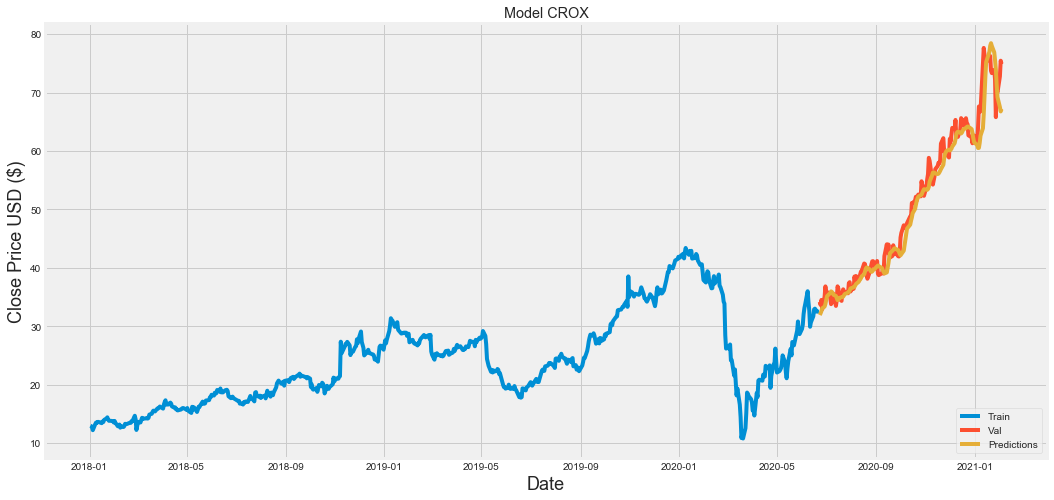

In [439]:
# Plot the data
for company in tech_list:
    train = data[company][:training_data_len]
    valid = data[company][training_data_len:]
    valid['Predictions'] = predictions[company]
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model'+" "+company)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [ ]:
#Show the valid and predicted prices
valid